In [18]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import glob
import os
from astropy.io import fits
import importlib.util
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.backends.backend_pdf
import re

In [19]:
# define functions to load architectures and pre-trained variables

def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path, bands):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture(bands=bands)
    return g, nn

def load_backup(sess, graph, backup):
    with graph.as_default():
        saver = tf.train.Saver()
        saver.restore(sess, backup)

In [20]:
# load a neural net with specified architecture
graph, nn = load_arch("arch_baseline_amount.py", 4)
sess = tf.Session(graph=graph)

# get pre-trained model
load_backup(sess, graph, '/Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_10000_finished/iter/010000.data')

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_10000_finished/iter/010000.data


In [57]:
# import unseen data from npz files
files = sorted(glob.glob('/Users/mac/Desktop/LBNL/challenge_data/GroundBasedTraining/npz/*.npz'))

In [58]:
# ALLX = []
x_list = []
for f in files[:10000]:
    x = np.load(f)['image']
    x_list.append(x)
#     b1 = x[:,:,0]
#     b2 = x[:,:,1]
#     b3 = x[:,:,2]
#     b4 = x[:,:,3]
#     full = np.stack([b1, b2, b3, b4], 2)
#     ALLX.append(full)
# ALLX = np.array(ALLX)
# ALLXmean = ALLX.mean()
# ALLXstd = ALLX.std()
x_array = np.array(x_list)
x_mean = x_array.mean()
x_std = x_array.std()
# print('ALLX\nmean: {}\nstd: {}'.format(ALLXmean, ALLXstd))
# print(ALLX.shape)
print('\nx_array\nmean: {}\nstd: {}'.format(x_mean, x_std))
print(x_array.shape)


x_array
mean: 1.2694646120071411
std: 11.19249153137207
(10000, 101, 101, 4)


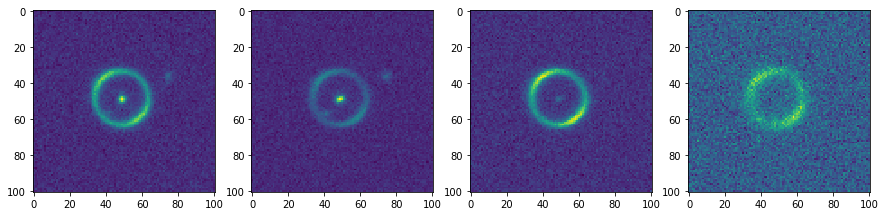

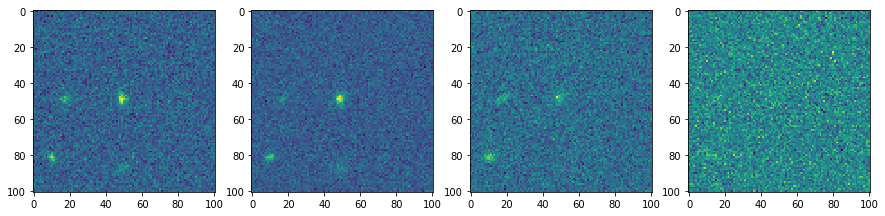

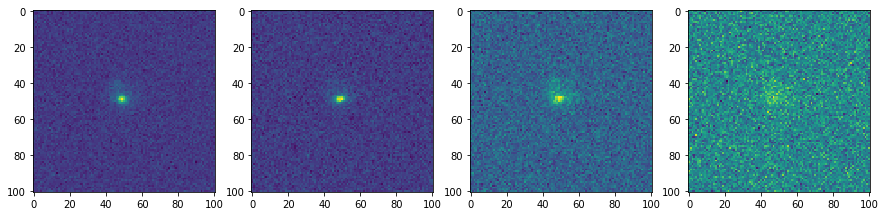

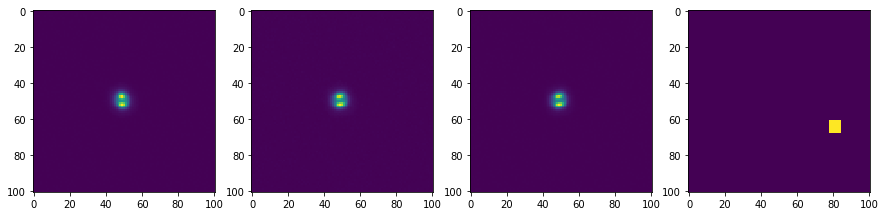

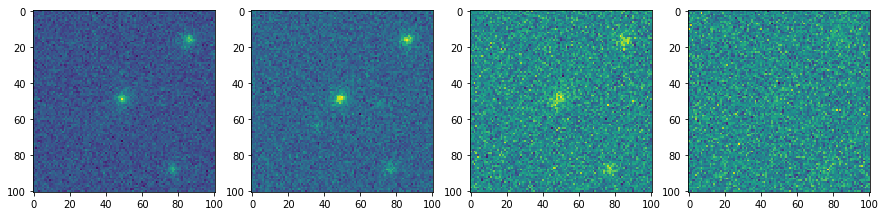

In [54]:
for img in x_array[:5]:
    plt.figure(figsize=(15,10))
    plt.subplot(141)
    plt.imshow(img[:,:,0])
    plt.subplot(142)
    plt.imshow(img[:,:,1])
    plt.subplot(143)
    plt.imshow(img[:,:,2])
    plt.subplot(144)
    plt.imshow(img[:,:,3])
    plt.show()

In [16]:
# get smaller dataset to test ROC
files_10000 = files[10000:20000]

# generate test data
X = []
y = []
for i in range(10000):
    x = np.load(files_10000[i])['image']
    X.append(x)
    y_ = np.load(files_10000[i])['is_lens']
    y.append(y_)
print("TEST DATA SET SIZE: ", len(X))

X_NP = np.array(X)
X_NP_5e10 = X_NP * 5e10
X_MP = (X_NP - X_NP.mean()) / X_NP.std()
X = nn.prepare(np.array(X))
y = np.array(y)

TEST DATA SET SIZE:  10000


In [ ]:
X_5e6 = X_NP * 5e7

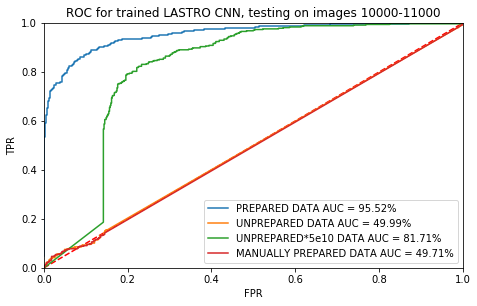

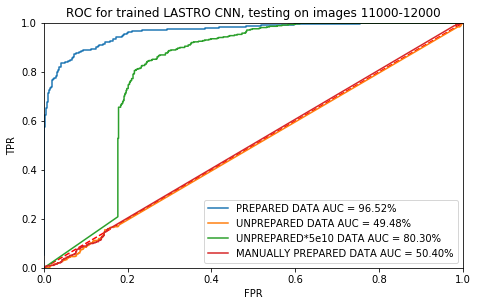

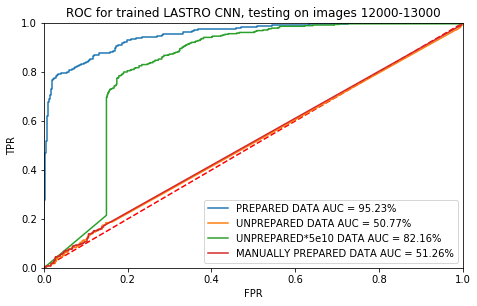

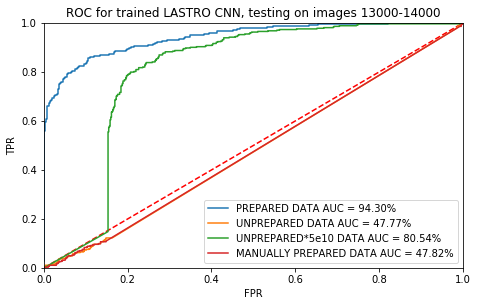

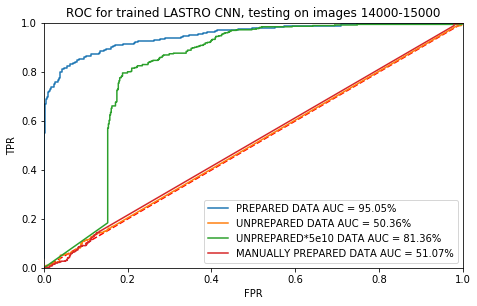

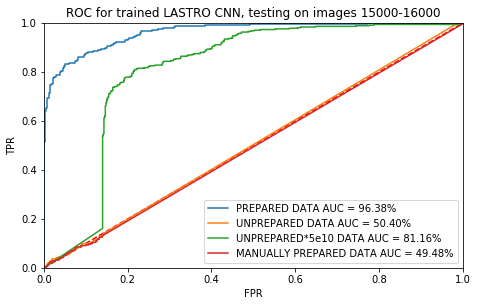

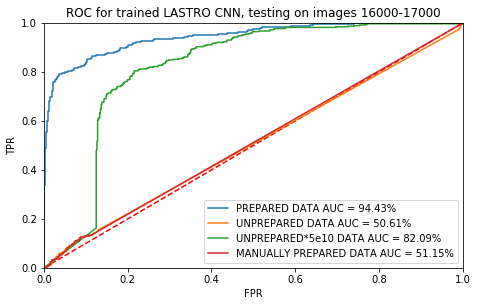

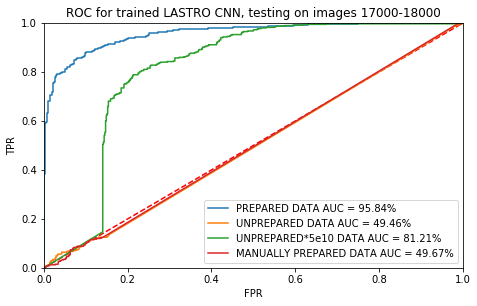

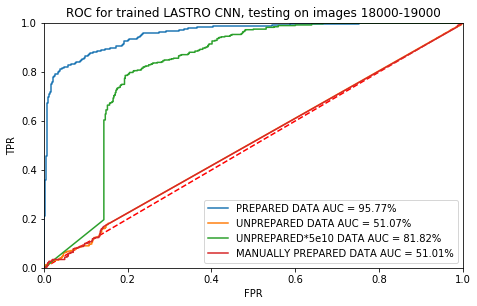

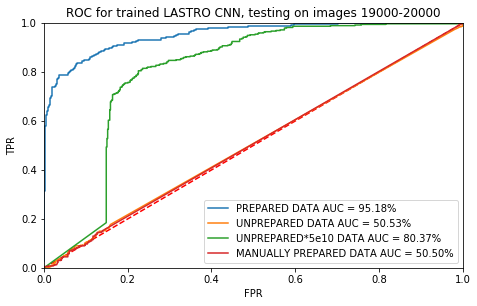

In [17]:
# get ROC curve for pre-trained LASTRO CNN on unseen data, using prepared and unprepared images

for i in range(10):
    start = i*1000
    end = i*1000 + 1000
    X_1000 = X[start:end] # split test set into smaller subsets, in this case 10 sets of 1000
    X_NP_1000 = X_NP[start:end]
    X_NP_5e10_1000 = X_NP_5e10[start:end]
    X_MP_1000 = X_MP[start:end]
    y_1000 = y[start:end]
    
    preds = nn.predict(sess, X_1000)
    fpr, tpr, threshold = roc_curve(y_1000, preds)
    roc_auc = auc(fpr, tpr)
    preds_NP = nn.predict(sess, X_NP_1000)
    fpr_NP, tpr_NP, threshold_NP = roc_curve(y_1000, preds_NP)
    roc_auc_NP = auc(fpr_NP, tpr_NP)
    preds_NP_5e10 = nn.predict(sess, X_NP_5e10_1000)
    fpr_NP_5e10, tpr_NP_5e10, threshold_NP_5e10 = roc_curve(y_1000, preds_NP_5e10)
    roc_auc_NP_5e10 = auc(fpr_NP_5e10, tpr_NP_5e10)
    preds_MP = nn.predict(sess, X_MP_1000)
    fpr_MP, tpr_MP, threshold_MP = roc_curve(y_1000, preds_MP)
    roc_auc_MP = auc(fpr_MP, tpr_MP)
    
    plt.figure(figsize=(7.5,4.5))
    plt.title('ROC for trained LASTRO CNN, testing on images {}-{}'.format(10000+start, 10000+end))
    plt.plot([0,1], [0,1], 'r--')
    plt.plot(fpr, tpr, label='PREPARED DATA AUC = {:0.2f}%'.format(roc_auc*100))
    plt.plot(fpr_NP, tpr_NP, label='UNPREPARED DATA AUC = {:0.2f}%'.format(roc_auc_NP*100))
    plt.plot(fpr_NP_5e10, tpr_NP_5e10, label='UNPREPARED*5e10 DATA AUC = {:0.2f}%'.format(roc_auc_NP_5e10*100))
    plt.plot(fpr_MP, tpr_MP, label='MANUALLY PREPARED DATA AUC = {:0.2f}%'.format(roc_auc_MP*100))
    plt.legend(loc='lower right')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig('LASTRO_ROC_imgs{}-{}'.format(10000+start, 10000+end))
    plt.show()

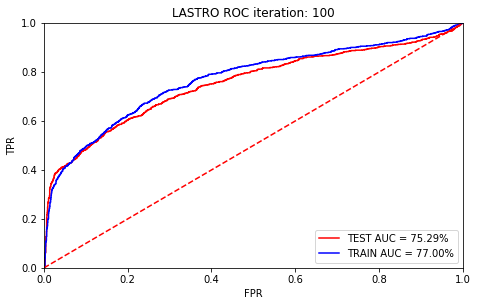

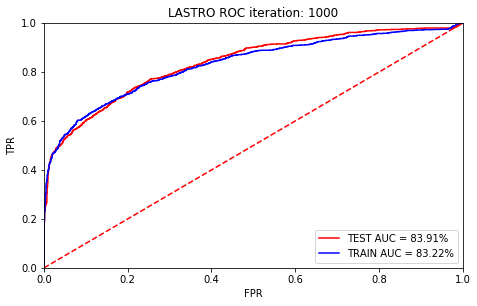

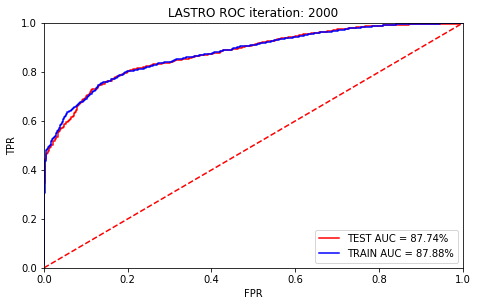

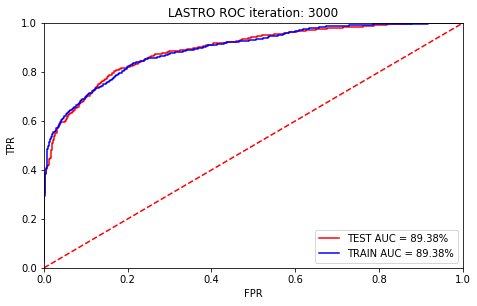

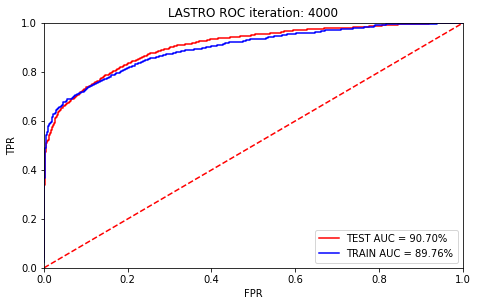

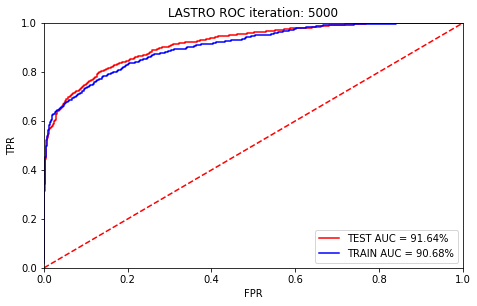

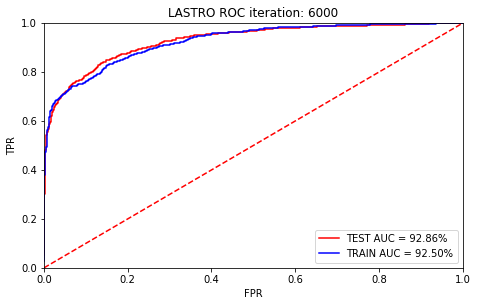

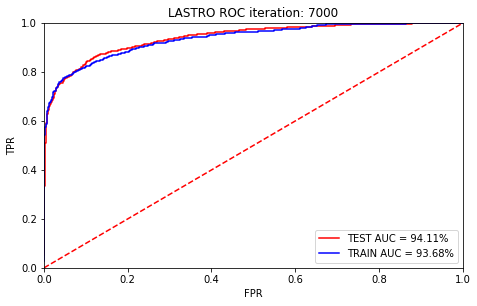

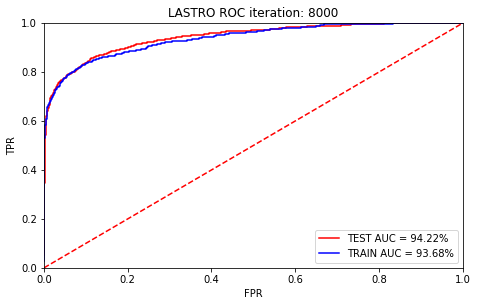

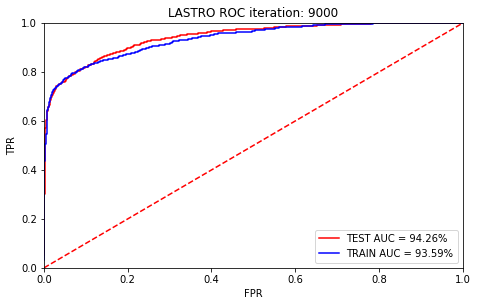

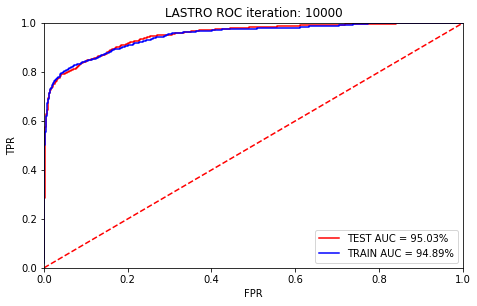

In [145]:
# plot ROC curve for LASTRO 10000_10000 across iterations (using saved data from training)

test_preds=[]
test_actual=[]
train_preds=[]
train_actual=[]
iterations=[i for i in range(100,10001,100)]

with open('C:/Users/Andrew/Desktop/LBNL/LASTRO/output_10000_10000_finished/stats_test.txt') as file:
    for line in file.readlines():
        line=line.split(' ')
        if line[0] != '#' and line[0] != '-1':
            probs=[]
            for i in range(1,len(line)):
                probs.append(float(line[i]))
            test_preds.append(probs)
        if line[0] == '-1':
             for i in range(1,len(line)):
                test_actual.append(float(line[i]))

with open('C:/Users/Andrew/Desktop/LBNL/LASTRO/output_10000_10000_finished/stats_train.txt') as file:
    for line in file.readlines():
        line=line.split(' ')
        if line[0] != '#' and line[0] != '-1':
            probs=[]
            for i in range(1,len(line)):
                probs.append(float(line[i]))
            train_preds.append(probs)
        if line[0] == '-1':
             for i in range(1,len(line)):
                train_actual.append(float(line[i]))

test_fpr, test_tpr, test_threshold = roc_curve(test_actual, test_preds[0])
test_roc_auc = auc(test_fpr, test_tpr)
train_fpr, train_tpr, train_threshold = roc_curve(train_actual, train_preds[0])
train_roc_auc = auc(train_fpr, train_tpr)

plt.figure(figsize=(7.5,4.5))
plt.title('LASTRO ROC iteration: {}'.format(iteration[0]))
plt.plot(test_fpr, test_tpr, 'r', label='TEST AUC = {:0.2f}%'.format(test_roc_auc*100))
plt.plot(train_fpr, train_tpr, 'b', label='TRAIN AUC = {:0.2f}%'.format(train_roc_auc*100))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

for i in range(9, 100, 10):   
    test_fpr, test_tpr, test_threshold = roc_curve(test_actual, test_preds[i])
    test_roc_auc = auc(test_fpr, test_tpr)
    train_fpr, train_tpr, train_threshold = roc_curve(train_actual, train_preds[i])
    train_roc_auc = auc(train_fpr, train_tpr)
    
    plt.figure(figsize=(7.5,4.5))
    plt.title('LASTRO ROC iteration: {}'.format(iteration[i]))
    plt.plot(test_fpr, test_tpr, 'r', label='TEST AUC = {:0.2f}%'.format(test_roc_auc*100))
    plt.plot(train_fpr, train_tpr, 'b', label='TRAIN AUC = {:0.2f}%'.format(train_roc_auc*100))
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

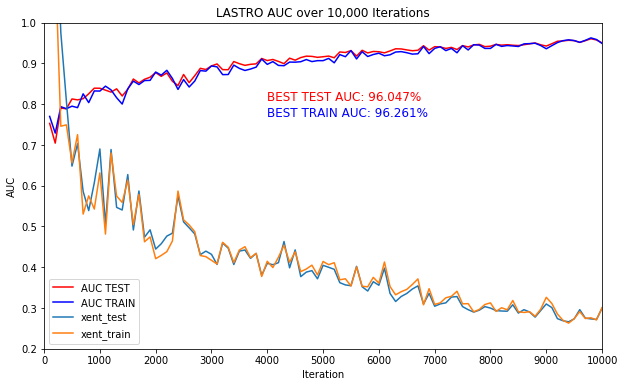

In [91]:
# AUC vs. iteration plot of LASTRO 10000_10000 (data from training)

iteration=[]
xent_test=[]
auc_test=[]
xent_train=[]
auc_train=[]
with open('C:/Users/Andrew/Desktop/LBNL/LASTRO/output_10000_10000_finished/metrics.txt') as file:
#     print((file.readlines()))
    for line in file.readlines():
        line=line.split(' ')
        if line[0] != '#':
            iteration.append(int(line[0]))
            xent_test.append(float(line[1]))
            auc_test.append(float(line[2]))
            xent_train.append(float(line[3]))
            auc_train.append(float(line[4]))

plt.figure(figsize=(10,6))
plt.title('LASTRO AUC over 10,000 Iterations')
plt.plot(iteration, auc_test, c='red', label='AUC TEST')
plt.plot(iteration, auc_train, c='blue', label='AUC TRAIN')
plt.plot(iteration, xent_test, label='xent_test')
plt.plot(iteration, xent_train, label='xent_train')
plt.text(4000, 0.81, 'BEST TEST AUC: {:.3f}%'.format(max(auc_test)*100), fontsize=12, color='red')
plt.text(4000, 0.77, 'BEST TRAIN AUC: {:.3f}%'.format(max(auc_train)*100), fontsize=12, color='blue')
plt.legend(loc='best')
plt.xlim([100,10000])
plt.ylim([0.2,1])
plt.xticks(range(0,10001,1000))
plt.ylabel('AUC')
plt.xlabel('Iteration')
plt.show()